
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Validation of the synthetic waves and level

inputs required: 
  * historical wave conditions
  * emulator output - synthetic wave conditions
  * emulator output - synthetic wave conditions associated to the future ENSO and TCs probability
  * Projected Sea Level Rise at the Site for the intermediate SLR scenario, +1m (to take into account in the TWL)

  
in this notebook:
  * Comparison of the extreme distributions
  * Analysis of the DWT resposible of extreme TWL events (from simulation with SLR and simulation with future ENSO & TCs prob. and SLR)
  


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator import Climate_Emulator
from teslakit.extremes import Peaks_Over_Threshold as POT
from teslakit.util.time_operations import xds_reindex_daily

from teslakit.plotting.extremes import Plot_ReturnPeriodValidation_CC
from teslakit.plotting.estela import Plot_DWTs_Probs
from teslakit.plotting.wts import Plot_Probs_WT_WT
from teslakit.plotting.outputs import Plot_LevelVariables_Histograms



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/media/administrador/HD/Dropbox/Guam/teslakit/data'
# p_data=r'/Users/laurac/Dropbox/Guam/teslakit/data'

# offshore
db = Database(p_data)
db.SetSite('GUAM')

# climate change - S6
db_S6 = Database(p_data)
db_S6.SetSite('GUAM_CC_S6')



In [3]:
# --------------------------------------
# Load complete hourly data for extremes analysis

# Historical
HIST_C_h = db.Load_HIST_OFFSHORE(decode_times=True)

# Simulation (1000yrs of all variables)
SIM_C_h = db.Load_SIM_OFFSHORE_all(decode_times=True, use_cftime=True)

# Simulation climate change TCs, ENSO & SLR (1000yrs of all variables)
SIM_C_h_CChange = db_S6.Load_SIM_OFFSHORE_all(decode_times=True, use_cftime=True)


In [4]:
# --------------------------------------
# Load SLR file
SLR = db.Load_SeaLevelRise()
SLR['time'] = SLR.time.dt.round('H')

# Select intermediate scenario (+1.0)
SLR = SLR.sel(scenario='1.0')


In [5]:
# def. some auxiliar function to select all dataset variables at vn max by groups

def grouped_max(ds, vn=None, dim=None):
    return ds.isel(**{dim: ds[vn].argmax(dim)})



## AWL - Annual Maxima Calculation

In [6]:
# Historical AWL Annual Maxima

# remove nans before and after AWL
ix_nonan = np.squeeze(np.argwhere(~np.isnan(HIST_C_h['AWL'].values[:])))
HIST_C_nonan = HIST_C_h.isel(time = ix_nonan)

# calculate AWL annual maxima dataset
hist_AMax = HIST_C_nonan.groupby('time.year').apply(grouped_max, vn='AWL', dim='time')


In [7]:
# Simulation AWL Annual Maxima

# calculate AWL annual maxima dataset
sim_AMax = SIM_C_h.groupby('time.year').apply(grouped_max, vn='AWL', dim='time')


In [8]:
# Simulation climate change AWL Annual Maxima

# calculate AWL annual maxima dataset
sim_AMax_CChange = SIM_C_h_CChange.groupby('time.year').apply(grouped_max, vn='AWL', dim='time')



## AWL - Annual Maxima Return Period

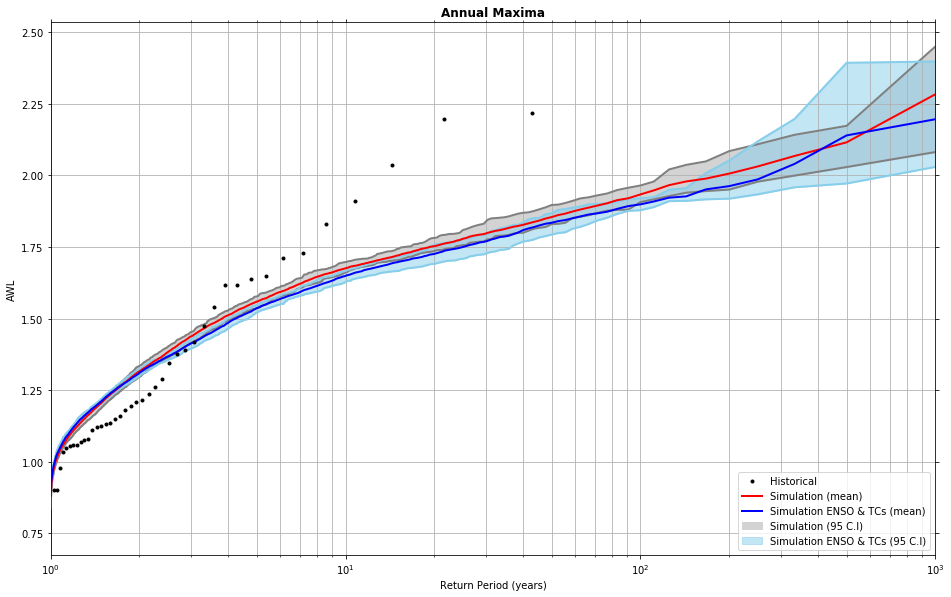

In [9]:
# AWL Annual Maxima Return Period (historical vs. simulations)

Plot_ReturnPeriodValidation_CC(hist_AMax['AWL'], sim_AMax['AWL'].transpose(), sim_AMax_CChange['AWL'].transpose(), label_1='Simulation', label_2 = 'Simulation ENSO & TCs');


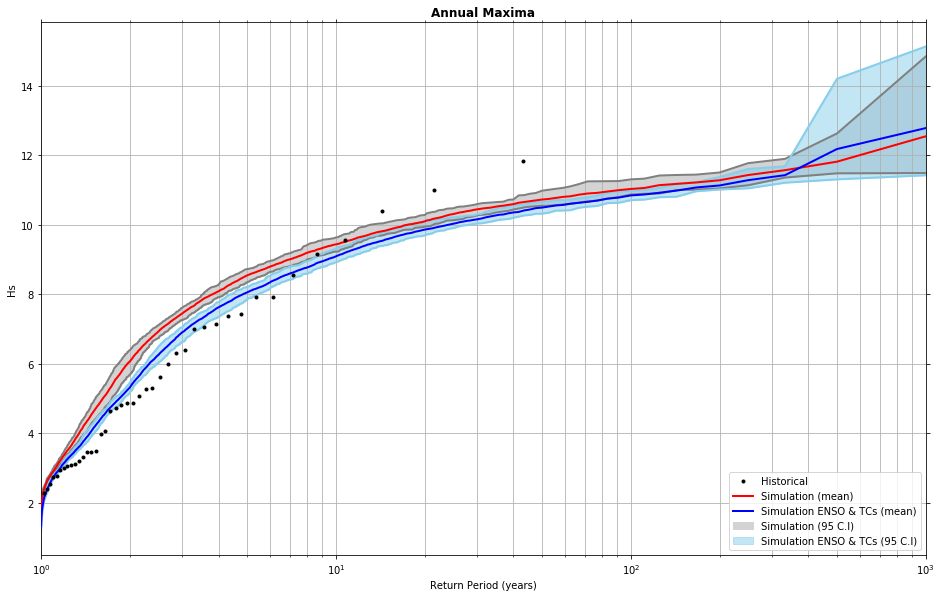

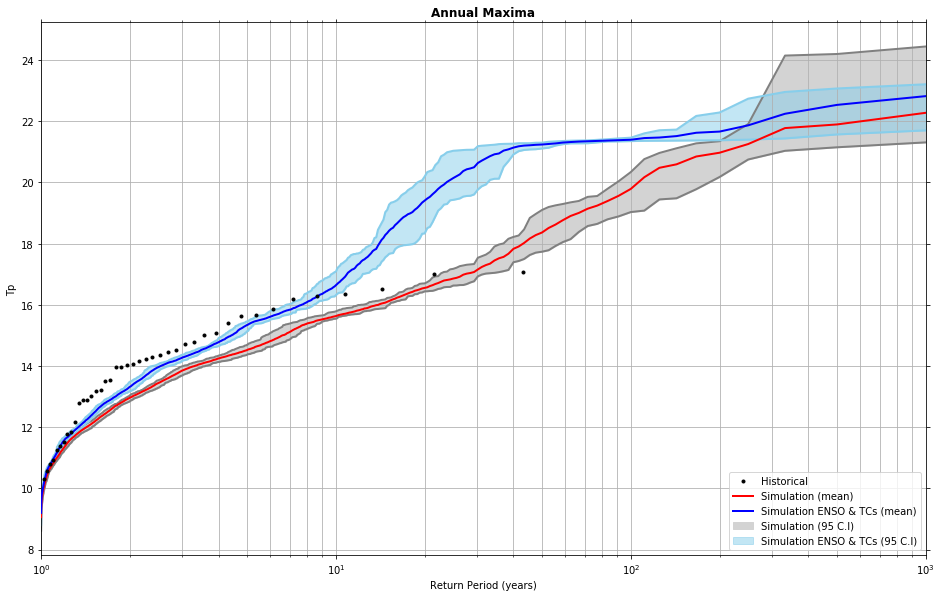

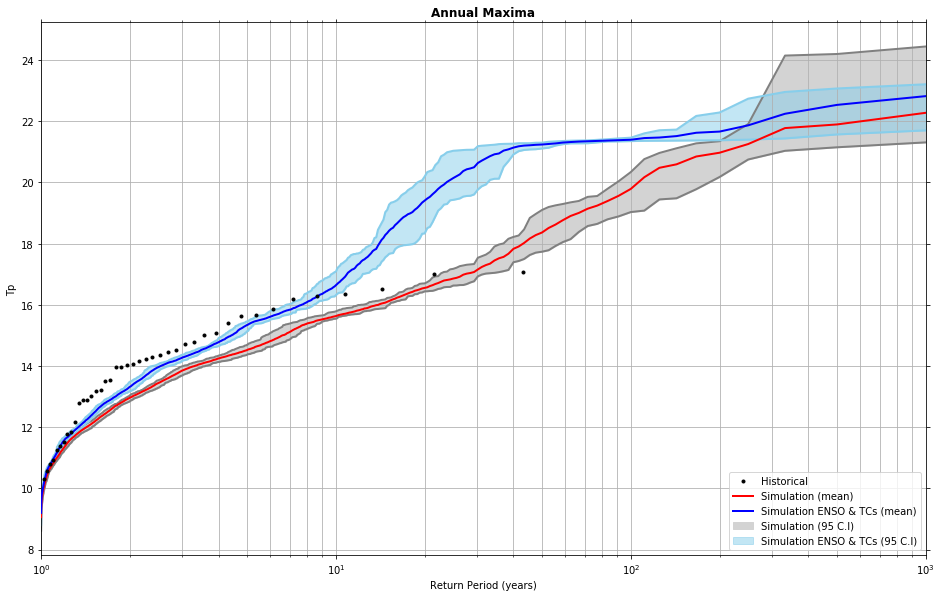

In [10]:
# Hs and Tp Return Period (historical vs. simulations) at AWL Annual Maxima

# Hs at AWL Annual Maxima
Plot_ReturnPeriodValidation_CC(hist_AMax['Hs'], sim_AMax['Hs'].transpose(), sim_AMax_CChange['Hs'].transpose(), label_1='Simulation', label_2 = 'Simulation ENSO & TCs')

# Tp at AWL Annual Maxima
Plot_ReturnPeriodValidation_CC(hist_AMax['Tp'], sim_AMax['Tp'].transpose(), sim_AMax_CChange['Tp'].transpose(), label_1='Simulation', label_2 = 'Simulation ENSO & TCs')



## AWL - Annual Maxima Probabilistic Plots

In [11]:
# Probabilistic plots parameters

n_clusters_AWT = 6    # number of AWT clusters
n_clusters_DWT = 42   # number of DWT clusters

# Select one simulation DWTs - WAVEs simulation
n_sim = 0
sim_AMax_n = sim_AMax.sel(n_sim=0)
sim_AMax_n_CChange = sim_AMax_CChange.sel(n_sim=0)


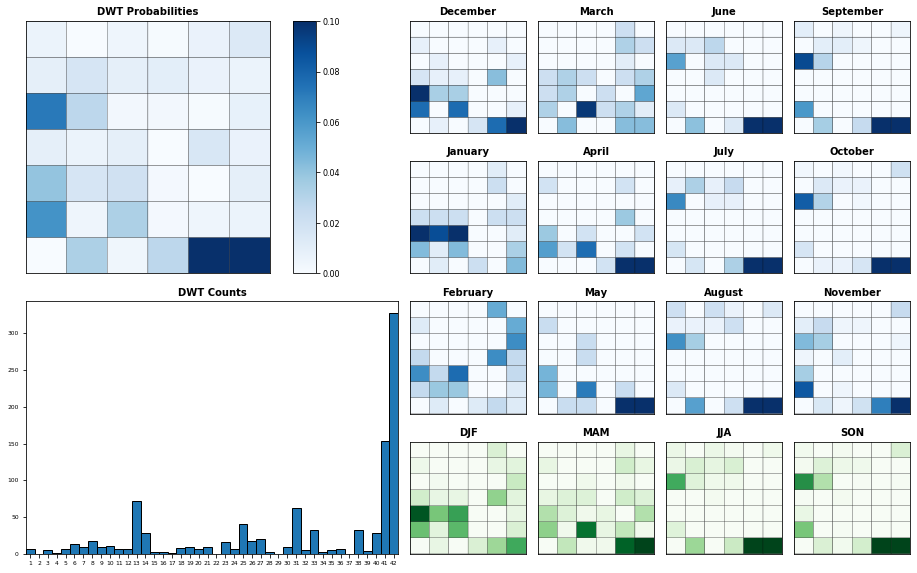

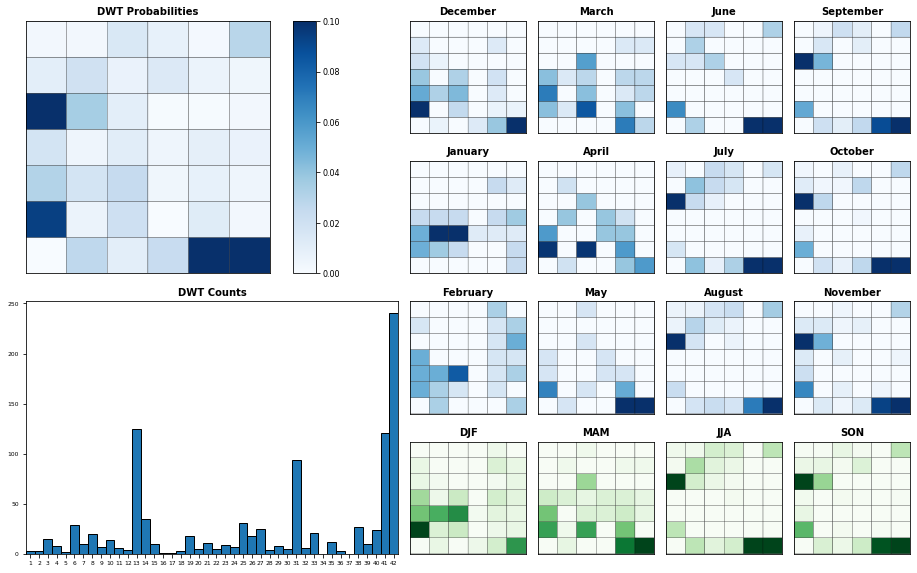

In [12]:
# Plot Annual Maxima DWT probabilities by month

# Simulation
Plot_DWTs_Probs(sim_AMax_n['DWT'].values, sim_AMax_n.time.values, n_clusters_DWT);

# Simulation climate change
Plot_DWTs_Probs(sim_AMax_n_CChange['DWT'].values, sim_AMax_n_CChange.time.values, n_clusters_DWT);


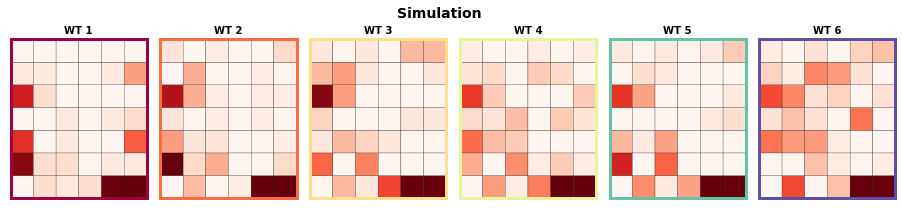

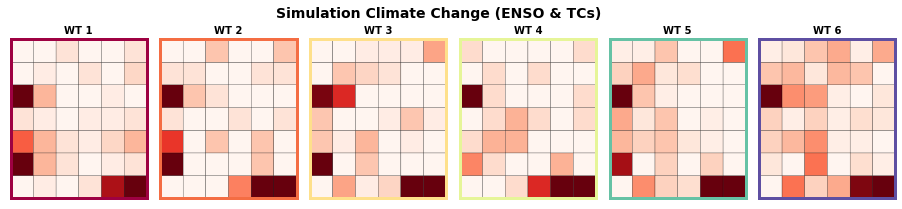

In [13]:
# Plot Annual Maxima AWTs/DWTs Probabilities 

# Simulation 
Plot_Probs_WT_WT(
    sim_AMax_n['AWT'].values[:] - 1, sim_AMax_n['DWT'].values[:] - 1, 
    n_clusters_AWT, n_clusters_DWT, wt_colors=True, ttl = 'Simulation',
);


# Simulation climate change
Plot_Probs_WT_WT(
    sim_AMax_n_CChange['AWT'].values[:] - 1, sim_AMax_n_CChange['DWT'].values[:] - 1, 
    n_clusters_AWT, n_clusters_DWT, wt_colors=True, ttl = 'Simulation Climate Change (ENSO & TCs)',
);



## AWL - Peaks Over Threshold Calculation


## AWL - Peaks Over Threshold Probabilistic Plots


## Level Variables (level, AT, MMSL, TWL) - Histograms

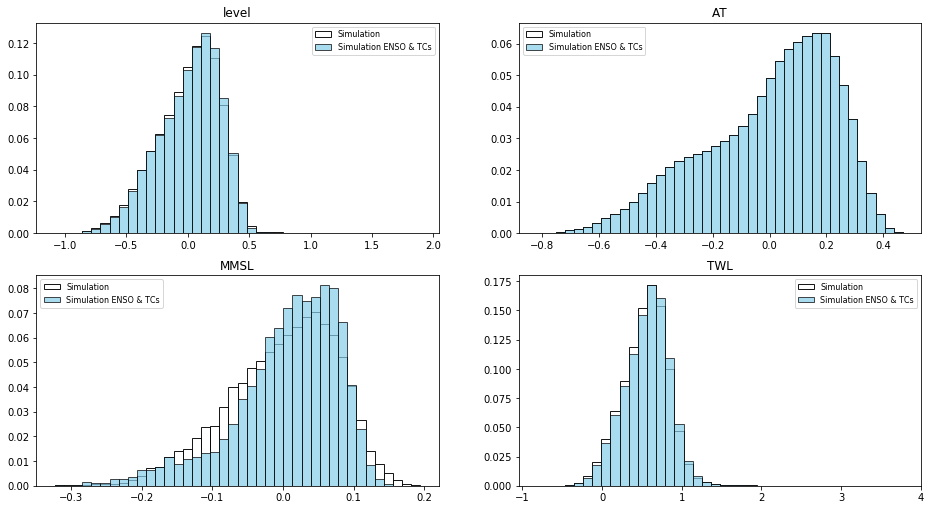

In [14]:
# Plot level, AT, MMSL and TWL histogram comparison between simulated data and climate change (ENSO & TCs) simulated data
Plot_LevelVariables_Histograms(SIM_C_h.sel(n_sim = 0), SIM_C_h_CChange.sel(n_sim = 0), label_1='Simulation', label_2 = 'Simulation ENSO & TCs', );


# Level variables taking into account SLR in the TWL (100 yrs. of simulated data)


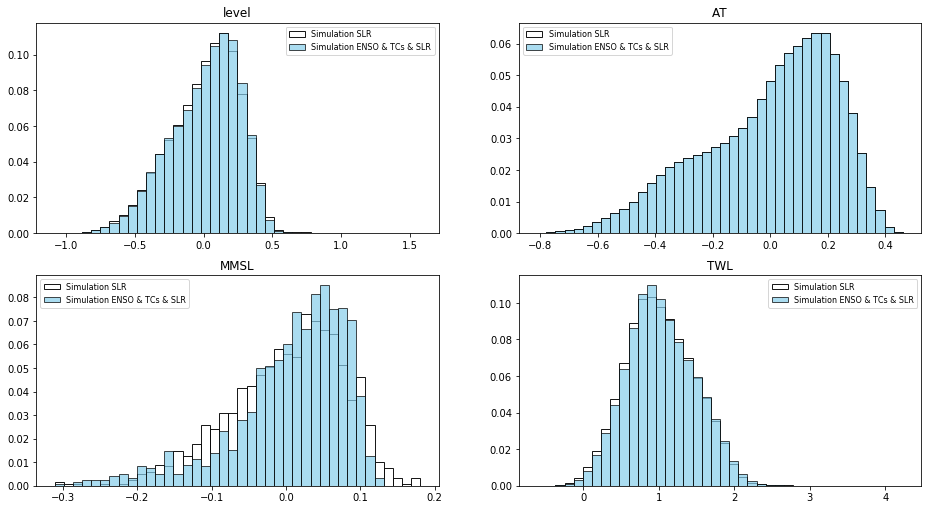

In [15]:
# Plot level variables of climate change simulated data: SLR vs ENSO+TCs+SLR

# select 100 yrs of simulation
SIM_C_h_SLR = SIM_C_h.isel(time=slice(0, len(SLR.time))).copy(deep=True) # 100 years
SIM_C_h_CChange_SLR = SIM_C_h_CChange.isel(time=slice(0, len(SLR.time))).copy(deep=True) # 100 years


# Add SLR to TWL
for n in range(0, len(SIM_C_h_SLR.n_sim)):
    SIM_C_h_SLR['TWL'][:,n] = SIM_C_h_SLR['TWL'].isel(n_sim=n) + SLR['SLR'].values
    SIM_C_h_CChange_SLR['TWL'][:,n] = SIM_C_h_CChange_SLR['TWL'].isel(n_sim=n) + SLR['SLR'].values


# Plot level, AT, MMSL and TWL histogram comparison between historical and simulated data
Plot_LevelVariables_Histograms(SIM_C_h_SLR.sel(n_sim = 0), SIM_C_h_CChange_SLR.sel(n_sim = 0), label_1='Simulation SLR', label_2 = 'Simulation ENSO & TCs & SLR');



## TWL - Annual Maxima. Simulations SLR vs. simulations SLR+ENSO

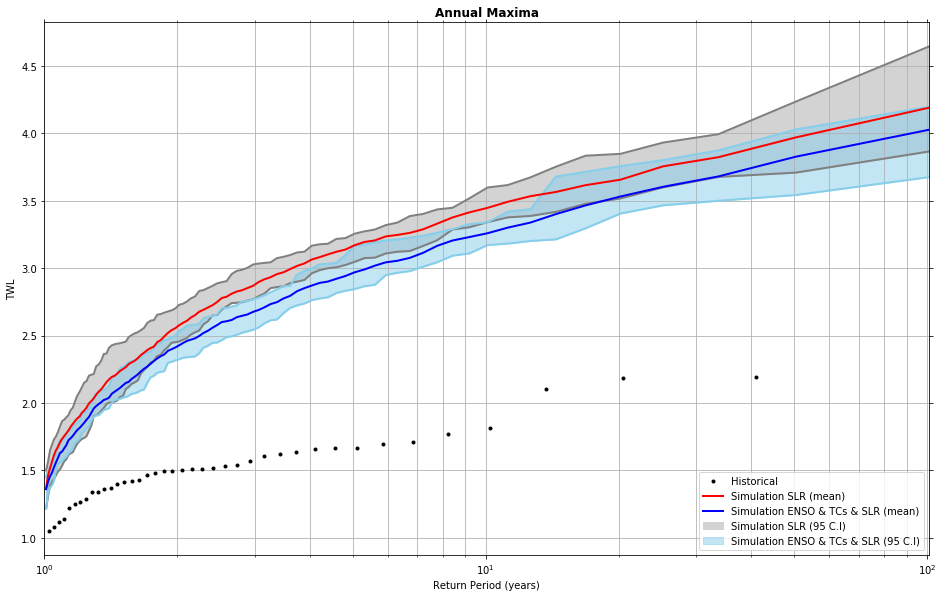

In [16]:
# Plot TWL annual maxima

# calculate Annual Maxima values for historical and simulated data
hist_A = HIST_C_h['TWL'].groupby('time.year').max(dim='time')
sim_A = SIM_C_h_SLR['TWL'].groupby('time.year').max(dim='time')
sim_B = SIM_C_h_CChange_SLR['TWL'].groupby('time.year').max(dim='time')

# Return Period simulations SLR vs. simulations SLR+ENSO+TCs
Plot_ReturnPeriodValidation_CC(hist_A, sim_A.transpose(), sim_B.transpose(), label_1='Simulation SLR', label_2 = 'Simulation ENSO & TCs & SLR' );
